In [13]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

import fncs as fn

In [25]:
importlib.reload(fncs)

<module 'fncs' from '/Users/lucaraffo/Desktop/codes/fncs.py'>

In [15]:
# synth
rng = np.random.default_rng(42)
d = 14
A = rng.normal(size=(d, d))
Sigma_true = A @ A.T + 0.3 * np.eye(d)
n = 2000
X = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma_true, size=n)

In [16]:
# score matching baseline (zero-mean)
Sigma_sm = fn.score_matching_cov_zero_mean(X, ridge=1e-12)

In [ ]:
print("||Sigma_sm - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_sm   - Sigma_true, 'fro')/np.linalg.norm(Sigma_true, 'fro'))

||Sigma_sm   - Sigma_true||_F/||Sigma_true||_F: 0.05055265637880741


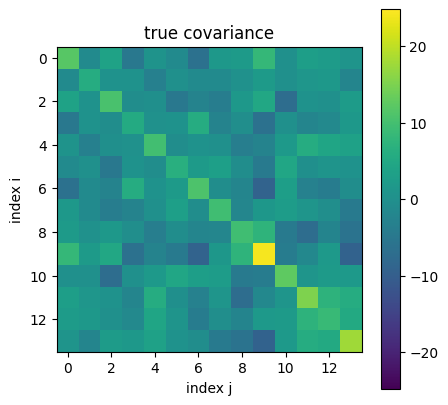

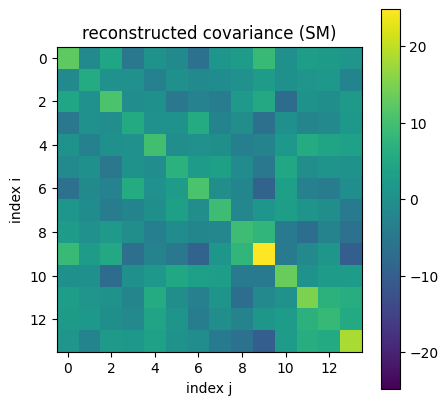

In [26]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_sm,
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (SM)")

In [42]:
# mmd—wasserstein-gradient fitting (choose kernel)

Sigma_rbf, a_rbf, val_rbf = fn.fit_cov_by_mmd_shrinkage(
    X, kernel="rbf", sigma_rbf=0.1, n_model=5000, seed=7, alphas=np.linspace(0,1,41)
)


In [43]:
print("||Sigma_rbf   - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_rbf   - Sigma_true, 'fro')/np.linalg.norm(Sigma_true, 'fro'))

||Sigma_rbf   - Sigma_true||_F/||Sigma_true||_F: 0.05055265637880666


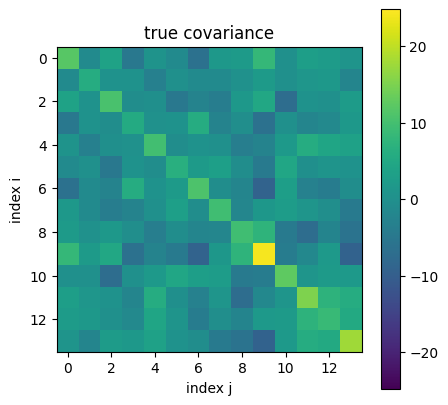

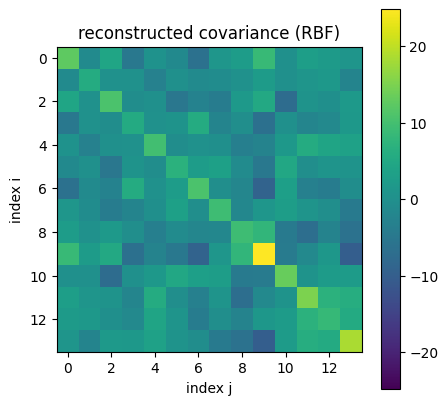

In [44]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_rbf,
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (RBF)")

In [34]:
Sigma_lin, a_lin, val_lin = fn.fit_cov_by_mmd_shrinkage(
    X, kernel="linear", n_model=5000, seed=7, alphas=np.linspace(0,1,41)
)

In [35]:
print("||Sigma_lin   - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_lin   - Sigma_true, 'fro')/np.linalg.norm(Sigma_true, 'fro'))

||Sigma_lin   - Sigma_true||_F/||Sigma_true||_F: 0.05055265637880666


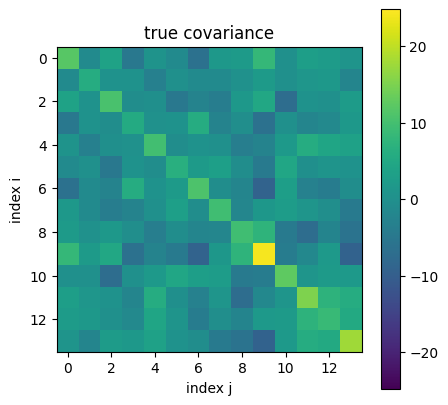

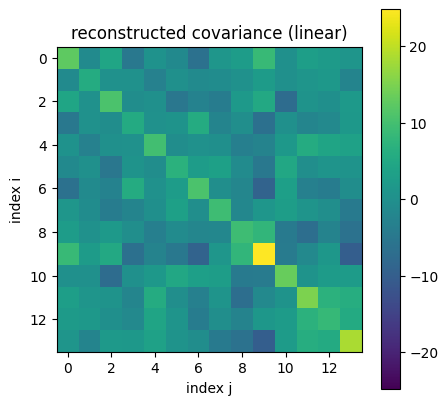

In [36]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_lin,
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (linear)")

In [37]:
Sigma_poly, a_poly, val_poly = fn.fit_cov_by_mmd_shrinkage(
    X, kernel="poly", degree=2, c=1.0, n_model=5000, seed=7, alphas=np.linspace(0,1,41)
)

In [40]:
print("||Sigma_poly   - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_poly   - Sigma_true, 'fro')/np.linalg.norm(Sigma_true, 'fro'))

||Sigma_poly   - Sigma_true||_F/||Sigma_true||_F: 0.05055265637880666


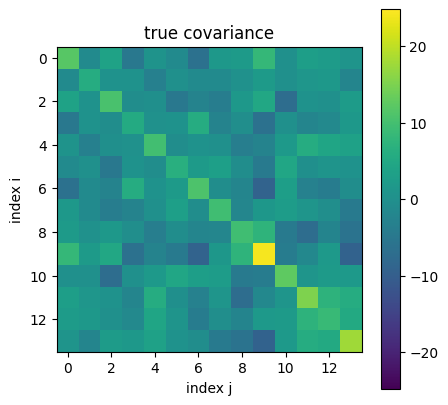

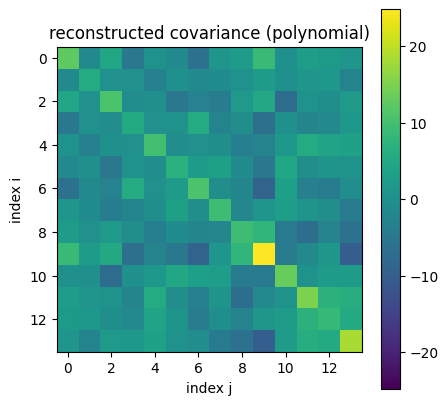

In [41]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_poly,
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (polynomial)")